# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Giacomo Barzon
* Francesco Fontana
* Lorenzo Mancini
* Giulio Vicentini

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from tqdm.auto import tqdm

from statsmodels.tsa.stattools import acf, pacf

from scipy.optimize import curve_fit

import imageio

# **INTRODUCTION**

The purpose of this project is to simulate a 2D Ising Model via Monte Carlo methods and to study the behaviour of some observables, like the magnetisation $m$, the specific heat $C_V$ and the magnetic susceptibility $\chi$.

## 2D Ising Model

We consider a 2-dimensional nearest-neighbour Ising Model with:
- $N^2=$ total number of sites on the lattice
- $\sigma_k \in \{+1,-1\}$ = individual spin site on the lattice

The Hamiltonian is:
$$ H(\vec{\sigma}) = - \sum_{<ij>} J_{ij} \sigma_i \sigma_j - \sum_i h_i\sigma_i$$
where $J_{ij}$ is the interaction strength and $h_i$ is the external local magnetic field.<br>
In this system, a particular configuration $\vec{\sigma}$ has the following probability:
$$ P(\vec{\sigma}) = \dfrac{e^{-\beta H(\vec{\sigma})}}{Z} $$
where
$$ Z = \sum_{ \{ \vec{\sigma} \} } e^{-\beta H(\vec{\sigma})} $$
is the partition function with $\beta = 1/k_B T$, and the sum is over all spin configurations of the system.


For $h = 0$, if the number of dimensions is larger than one, the Ising model shows a 2nd-order phase transitions. Then, below a certain critical temperature, a spontaneous magnetization occurs. For $d = 2$, the transition temperature has been calculated analytically by Onsager:
<br>
$$ T_C = \dfrac{2}{\ln(1 + \sqrt{2})} $$

In our simulation, for simplicity, we choose an uniform ferromagnetic medium (i.e. $J_{ij}=J=1$) and no external field (i.e. $h_i=h=0$ ). We also fix $k_B = 1$. In this way our hamiltonian reduces to:
$$ H(\vec{\sigma}) = - \sum_{<ij>} \sigma_i \sigma_j$$
Finally we set the periodic boundary conditions, so all the spins have the same number of neighobours.

We start with a random configuration:

In [3]:
@jit(nopython=True)
def init_state(N):
  '''
  Return a random spin configuration in a 2d square lattice
  '''
  return np.random.choice(np.array([-1,1]),size=(N,N))

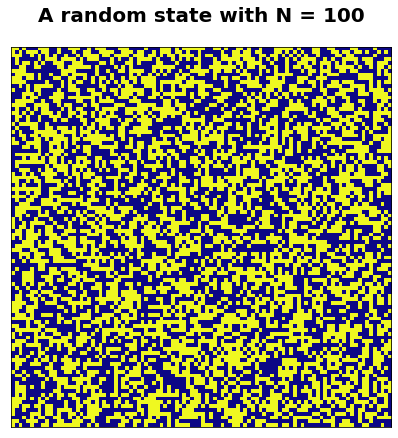

In [4]:
#show an example
try_state = init_state(100)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(try_state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 20, fontweight = "bold" )
plt.show()

## Metropolis-Hastings algorithm

In order to simulate the behaviour of this model, we need to compute the transition probability $W(\sigma \rightarrow \sigma')$ from one state $\sigma$ to the next state $\sigma'$. This can be written as the product of the selection probability $g$ and the acceptance probability $A$:
$$ W(\sigma \rightarrow \sigma') = g(\sigma \rightarrow \sigma')* A(\sigma \rightarrow \sigma') $$
- For the former, following the Glauber dynamics, we chose to implement a Monte Carlo algorithm based on local moves. In this case the selection probability is clearly uniform:
$$g(\sigma \rightarrow \sigma') = 1/N^2$$
- For the second one we set that te acceptance probability must respect the Metropolis-Hasting rule:
<br>
$$ A(\sigma \rightarrow \sigma') = 
\begin{cases} 
e^{ - \beta ( E_{\sigma'} - E_{\sigma} ) } \ \ \ \ \ if \ E_{\sigma'} - E_{\sigma}>0
\\
1 \hspace{2.5cm} otherwise
\end{cases} $$

So, imposing the detailed balanced condition for the the transition probabilities, we simply obtain:
<br>
$$ \dfrac{W(\sigma \rightarrow \sigma')}{W(\sigma' \rightarrow \sigma)} = \dfrac{A(\sigma \rightarrow \sigma')}{A(\sigma' \rightarrow \sigma)} = \dfrac{P(\sigma')}{P(\sigma)} = e^{ - \beta ( E_{\sigma'} - E_{\sigma} ) }$$

And thanks to the Single-Flip dynamics is possibile to simplify further, in fact:
<br>
$$ \Delta E = E_{\sigma'} - E_{\sigma} = -(\sigma_i' - \sigma_i) \sum_{j \in n.n.(i)} \sigma_j = 2 \sigma_i \sum_{j \in n.n.(i)} \sigma_j$$

In [5]:
@jit(nopython=True)
def energy(state):
  '''
  Energy of a given configuration
  '''
  N = state.shape[0]
  energy = 0
  
  # Loop over all sites
  for i in prange(N):
    for j in prange(N):

      # get nearest neighbours states
      nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
      # compute site energy
      energy -=  state[i,j] * nn

  # Divide energy by 2, since we count each site contribution to each of the 2 neighbours 
  return energy / 2 

In [6]:
@jit(nopython=True)
def glauber(state, beta):
  '''
  Spin-flip according to Metropolis-Hastings algorithm
  '''
  N = state.shape[0]

  for n in prange(N**2):

      # choose a spin site with uniform probability
      i, j = np.random.randint(N), np.random.randint(N)

      # get sum of nearest neighbour values in the lattice
      nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N] # the modulo % operation takes care of the boundaries condition
      
      # get delta energy
      delta = 2 * state[i,j] * nn

      # Metropolis
      if delta < 0 or np.random.random() < np.exp(- beta * delta):
        state[i,j] = -1. * state[i,j]
        
  return state

### Example of single spin flip

Example of single spin flip:


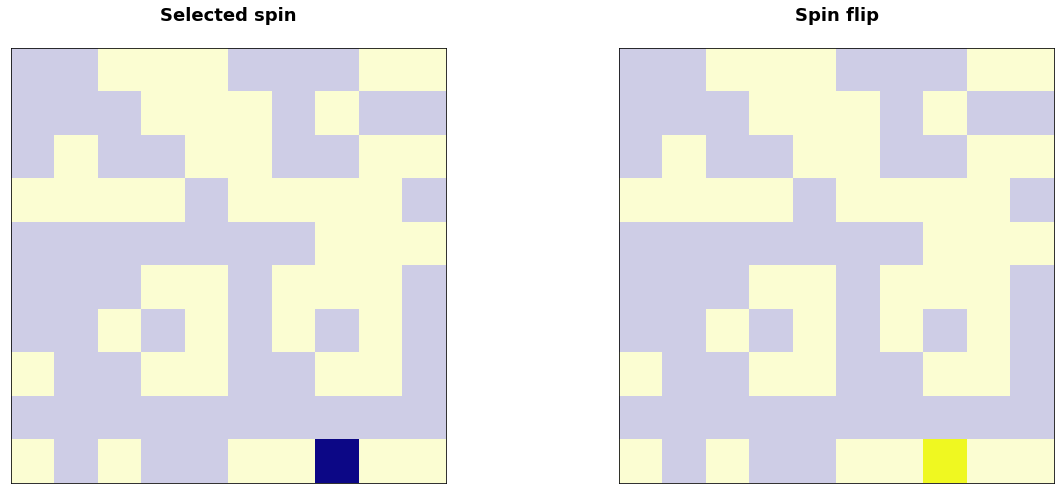

In [9]:
N = 10
beta = 1
state = init_state(N)
new_state = state.copy()

alpha = np.full((N,N), 0.2)
i, j = np.random.randint(N), np.random.randint(N)
new_state[i,j] = -1. * new_state[i,j]

selected_spin = np.where(state != new_state)
alpha[selected_spin[0], selected_spin[1]] = 1

print("Example of single spin flip:")

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,8))
ax1.matshow(state, cmap = plt.cm.plasma, alpha = alpha)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Selected spin", fontsize = 18, fontweight = "bold")
ax2.matshow(new_state, cmap = plt.cm.plasma, alpha = alpha)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Spin flip", fontsize = 18, fontweight = "bold")
plt.show()

In [10]:
def Ising(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = False, verbose=True):
    '''
    Run a simulation of a 2d Ising model

    Parameters:
    - N: number of sites per dimension
    - beta
    - eq_steps: initial steps for the equilibration phase
    - steps: effective steps of the simulation
    - order: generate a ordered configuration with uniform magnetisation
    - annealing: using simulating annealing during equilibration
    - cluster: to use the Wolff algorithm
    - verbose: more detailed output during simulation
    
    Output:
    - E_mean: Mean energy 
    - M_mean: Mean magnetization
    - Cs: Specific heat
    - Chis: Susceptibility
    - E_var: Energy error
    - M_var: Magnetisation error
    - E_eq: Energy on equilibration
    - M_eq: Magnetisation on equilibration
    - E: Energy on simulation
    - M Magnetisation on simulation

    '''
    
    if verbose:
        print('---------- ISING MODEL ----------')
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')

        print('Start equilibration...')

  # Init state
    if order:
        curr_state = np.ones((N,N))
    else:
        curr_state = init_state(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
  
    if annealing:
        ### Equilibation with SA
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
    ### Equilibration
        betas = np.zeros(eq_steps) + beta
      
  # Loop over time steps
    if verbose:
        for i in tqdm(range(eq_steps)):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = glauber(curr_state, betas[i])

        print('End equilibration...\n')
    
    else:
        for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = glauber(curr_state, betas[i])
        
  ### Simulation
    if verbose:  
        print('Start simulation...')

  # Define arrays for storing state observables
    E = np.zeros(steps)
    M = np.zeros(steps)
  
    if verbose:
        for i in tqdm(range(steps)):
            #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
            # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = glauber(curr_state, beta)
        print('End simulation...')
    
    else:
        for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
          # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = glauber(curr_state, beta)

    ### Compute observables
    E_mean, M_mean, C, Chi = np.mean(E), np.mean(M), beta**2*np.std(E)**2, beta*np.std(M)**2
    E_var, M_var = np.std(E), np.std(M)

  ### Return results
    return (E_mean, M_mean, C, Chi,
            E_var, M_var,
            E_eq, M_eq, E, M) 

# **SIMULATION**

Before starting with the analysis of the system we can check if the model behaves as expected, testing the outputs for different inputs.
<br>
Here we plot the energy and the magnetisation during the equilibration for some values of temperature.

---------- ISING MODEL ----------
N: 20 , beta: 0.2 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 0.44 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 1.0 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


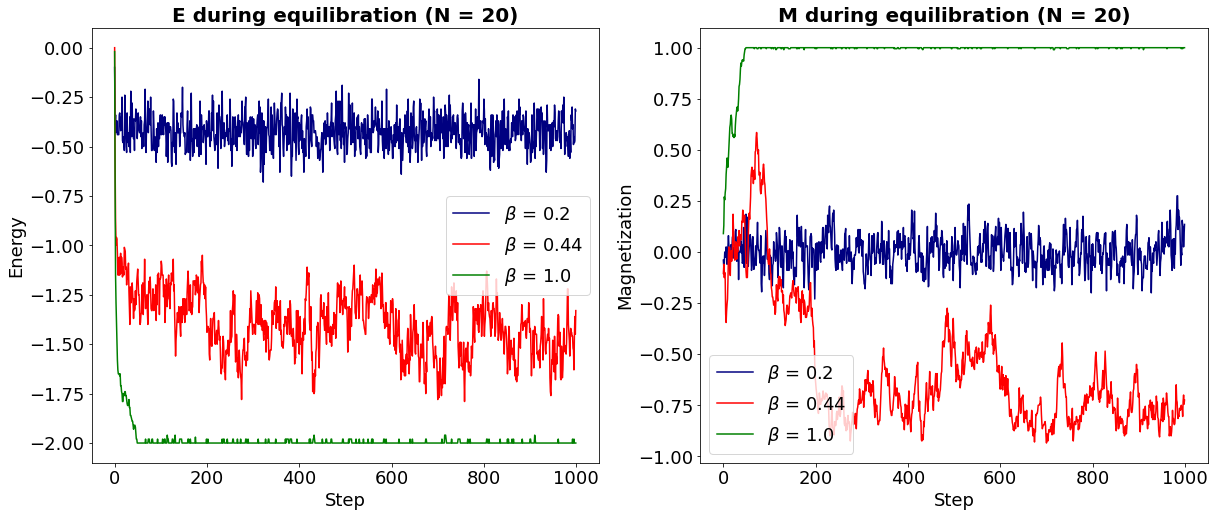

In [14]:
N = 20 #size of lattice
eq_steps = 1000 #define number of equilibration steps
steps = 100 #define number of simulation steps
betas = np.array([0.2, 0.44, 1]) #values of beta to be used
col_map = np.array(["navy", "red", "green", "orange"])

#create plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
ax1.set_title(r"E during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)

#loop over betas and compute values
for i in range(len(betas)):    
    E_mean, M_mean, C, Chi, E_var, M_var, E_eq, M_eq, E, M = Ising(N, betas[i], eq_steps, steps)
    
    ax1.plot(E_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    ax2.plot(M_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    
ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()

Another check that we can do to test if the model responds appropriately is to simulate a fully ordered state and to see if it reach the same equilibrium state of a random one, setting the temperature.
<br>


---------- ISING MODEL ----------
N: 20 , beta: 0.3 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 0.3 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


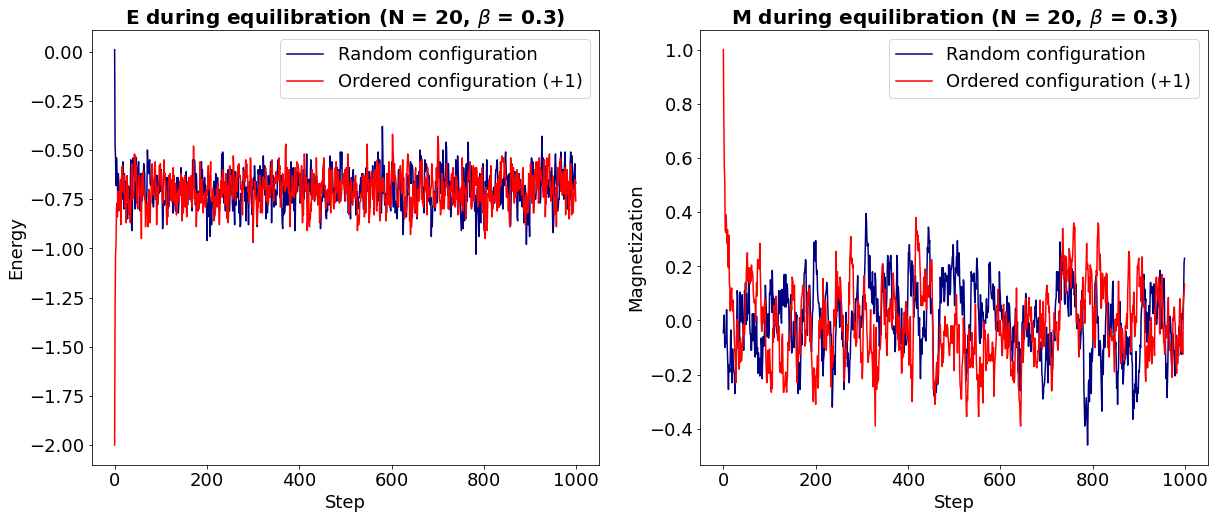

In [15]:
N = 20 #size of the lattice
beta = 0.3 #beta to be used
eq_steps = 1000
steps=100

#simulations
E_mean, M_mean, C, Chi, E_var, M_var, E_or, M_or, E, M = Ising(N, beta, eq_steps, steps, order=True)
E_mean, M_mean, C, Chi, E_var, M_var, E_ran, M_ran, E, M = Ising(N, beta, eq_steps, steps)

#plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax1.plot(E_ran/N**2, c = "navy", label = "Random configuration")
ax1.plot(E_or/N**2, c = "red", label = "Ordered configuration (+1)")
ax2.plot(M_ran/N**2, c = "navy", label = "Random configuration")
ax2.plot(M_or/N**2, c = "red", label = "Ordered configuration (+1)")
ax1.set_title(r"E during equilibration (N = {}, $\beta$ = {})".format(N, beta), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {}, $\beta$ = {})".format(N, beta), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)
ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()

## Simulated Annealing

The first issue that we face during the simulation of the systems occurs approaching very low temperatures. In this case, indeed, is possible that the system remains stucked in a local minimum, whitout the possibility of reach the global minimum of the configurations. As we can see in this plot.

---------- ISING MODEL ----------
N: 20 , beta: 100 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


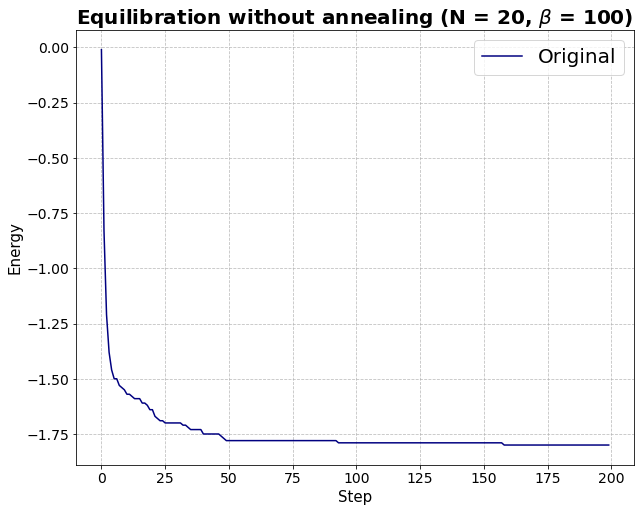

In [18]:
N = 20
beta = 100

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M,  = Ising(N, beta, eq_steps=int(200), steps=int(100))

#plot
fig = plt.figure( figsize=(10, 8) )
plt.plot(E_eq / N**2,  "navy", label = "Original")
plt.title(r'Equilibration without annealing (N = {}, $\beta$ = {})'.format(N, beta), fontsize = 20, fontweight = "bold" )
plt.xlabel('Step', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.grid(linestyle = "--", alpha = 0.8)
plt.tick_params(axis="x",labelsize=14)
plt.tick_params(axis="y",labelsize=14)
plt.legend(fontsize = 20)
plt.show()

Is clear that, in this case of low temperature ($\beta=100 $), the system is stucked in a global minimum of energy around $\sim -1.75$, instead of reach the global one $E=-2$.
<br>
The solution comes from a very simple idea called *Simulated Annealing* (SA). In order to avoid this problem we help the system to jump this local minima with a sort of "slow cooling", starting the system from an high temperature and cooling down linearly with the steps. <br>
Here we compare the two procedure in the same plot (whit SA in orange, without SA in blu). The results are clear.

---------- ISING MODEL ----------
N: 20 , beta: 100 , cluster: False , annealing: True 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


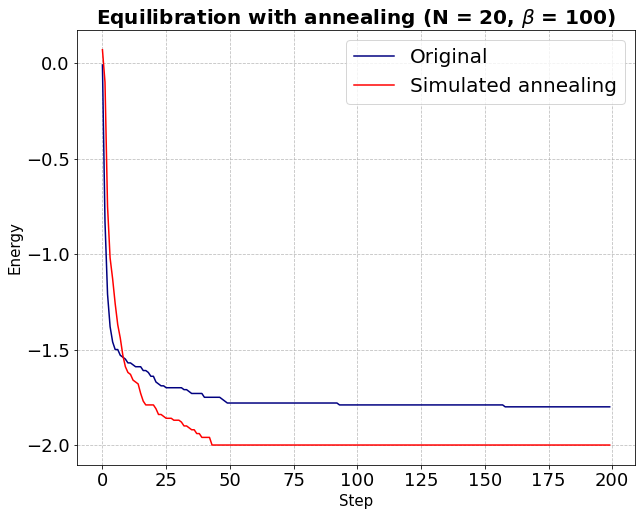

In [21]:
N = 20
beta = 100

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq_SA, M_eq, E, M,  = Ising(N, beta, eq_steps=int(200), steps=int(100), annealing=True)

#plot
fig = plt.figure( figsize=(10, 8) )
plt.plot(E_eq / N**2,  "navy", label = "Original")
plt.plot(E_eq_SA / N**2,  "red", label = "Simulated annealing")
plt.title(r'Equilibration with annealing (N = {}, $\beta$ = {})'.format(N, beta), fontsize = 20, fontweight = "bold" )
plt.xlabel('Step', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.grid(linestyle = "--", alpha = 0.8)
plt.tick_params(axis="x",labelsize=18)
plt.tick_params(axis="y",labelsize=18)
plt.legend(fontsize = 20)
plt.show()

# **ANALYSIS**

We are now ready to proceed with the analysis of the behaviour of the different observables in function of the temperature $T$ and of the size of the system $N$.

One finds
$$E=-\sum_{\langle ij \rangle}\sigma_i\sigma_j \qquad M=\sum_i\sigma_i$$
$$C_v=\frac{\partial\langle E\rangle}{\partial T}=\beta^2(\langle E^2\rangle - \langle E\rangle^2)=\beta^2\cdot var_{\vec{\sigma}}(E) \qquad \chi=\frac{\partial\langle M\rangle}{\partial h}=\beta(\langle M^2\rangle - \langle M\rangle^2)=\beta \cdot var_{\vec{\sigma}}(M)$$
where $\langle \cdot\rangle$ indicates the mean over all the configurations $\{\vec{\sigma}\}$

To compare better the results for different size of the systems, we plot all the quantities for single spin, so we divide for the total number of spins $N^2$

## Phase transition

In [136]:
### ------Computing the simulation changing beta and the lattice size
N_T = 40
Ts = np.linspace(0.75, 3.75, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10,20,30,40,50]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
Cs = np.zeros((N_N, N_T))
Chis = np.zeros((N_N, N_T))

#simulation
for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M,  = Ising( N, beta, eq_steps=eq_steps, steps=steps, annealing=False, cluster=False,verbose=False  )

    #save values
    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    Cs[i,j] = C_mean
    Chis[i,j] = Chi_mean

Simulating N=10



Simulating N=20



Simulating N=30



Simulating N=40



Simulating N=50


In [157]:
def plot_values (Es,Ms,Cs,Chis,N,startN=0,endN=Es.shape[0]-1):
    titles=['Energy','Magnetisation','Specific Heat','Susceptibility']
    physical_quantities=[Es,np.abs(Ms),Cs,Chis]
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(startN,endN+1):
            ax.plot(Ts[1:], physical_quantities[i][j][1:] / N[j]**2, '.',markersize=9, label='N='+str(N[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

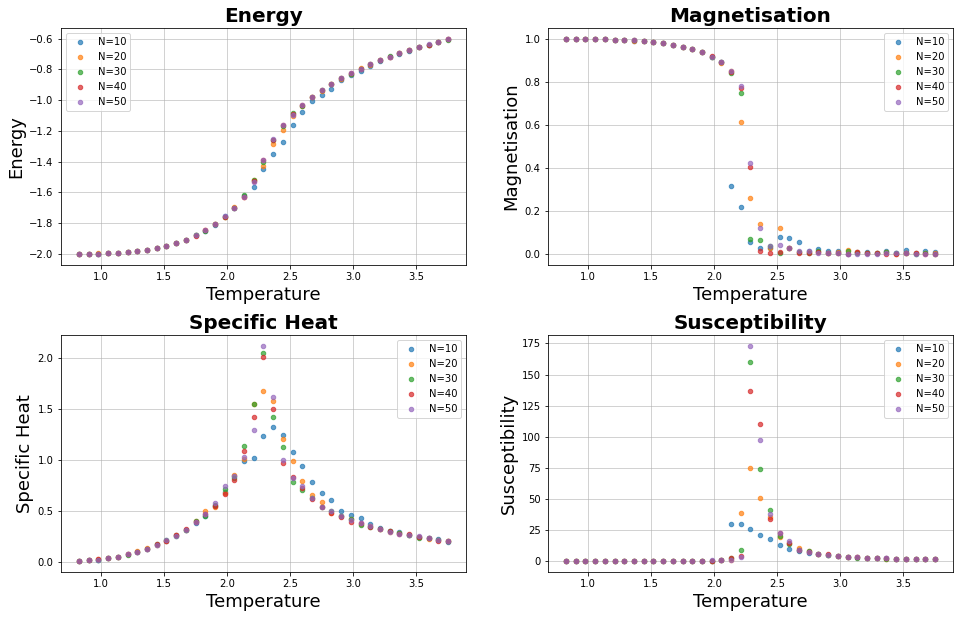

In [158]:
plot_values(Es,Ms,Cs,Chis,Ns,startN=0,)

The Ising model is a paradigmatic model of statistical mechanics that allow to observe some very interesting phenomena like the phase transition. In particular, from the plot of the magnetisation $m$, is clear how, going through the critical point, the systems change from a paramagnetic phase (with no magnetisation) to a ferromagnetic phase (in which a spontaneous magnetisation emerges). This effect is one of the simplest examples of the *simmetry breaking*.
<br>


## Critical exponent estimation

From the theory we know that the some observables satisfy a scaling ansatz. In the case of the susceptibility, one finds $\chi \sim |T-T_c|^{-\gamma}$, where $\gamma$ is the so-called *critical exponent* and, in the thermodynamic limit $N\rightarrow\infty$, it holds $\gamma=7/4$. 
We try to infere this value fitting $\chi$ for increasing values of $N$.

In [26]:
def func_powerlaw(T, k=1, gamma=-1, Tc=2.26):
    return k * np.abs(T-Tc)**gamma

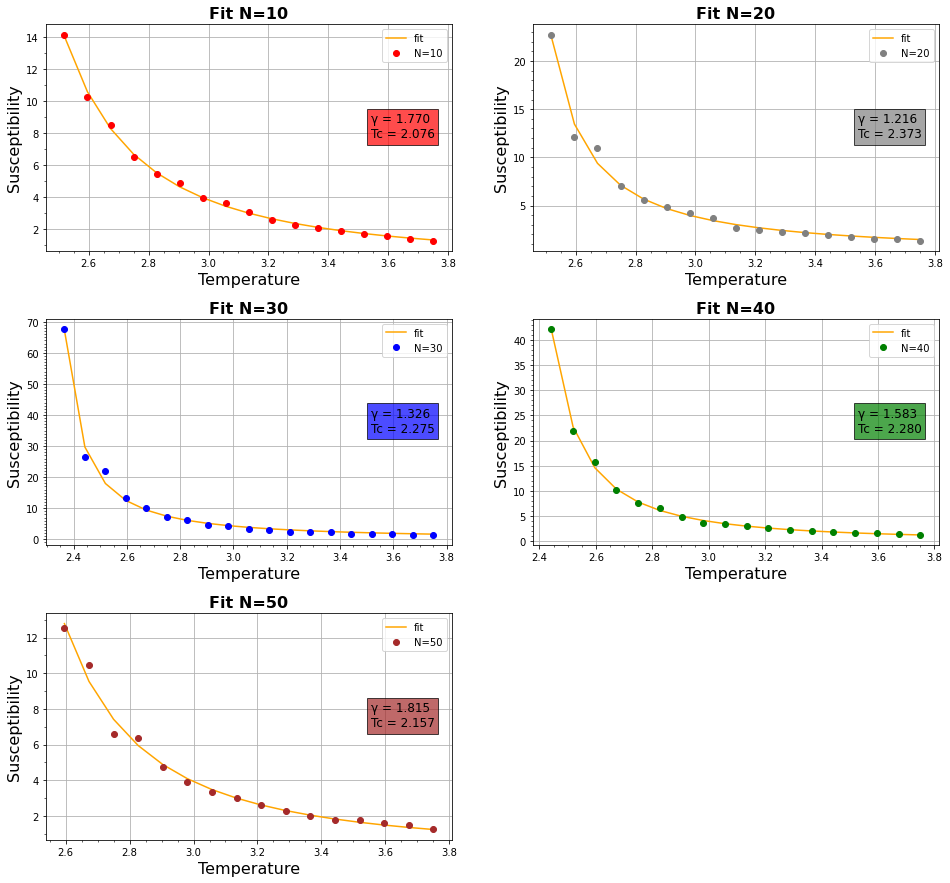

In [28]:
N_T = 40
Ts = np.linspace(0.75, 3.75, endpoint=True, num=N_T)

tt = [8, 4, 4, 4, 5]
N = [10,20,30,40,50]
Ks = np.zeros(5)
gammas = np.zeros(5)
TCs = np.zeros(5)
col=['red','grey','blue','green', 'brown']

plt.figure(figsize=(16,15))
for i, Chi in enumerate(Chis):
  ax=plt.subplot(3,2,i+1)
    
  #fit
  Tmax = np.argmax(Chi[2:])
  sol,cov = curve_fit(func_powerlaw, Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, maxfev=int(1e6) )
  Ks[i] = sol[0]
  gammas[i] = sol[1]
  TCs[i] = sol[2]
    
  #plot
  ax.plot(Ts[Tmax+tt[i]:], func_powerlaw(Ts[Tmax+tt[i]:], Ks[i], gammas[i], TCs[i]),'orange', label='fit')
  ax.plot(Ts[Tmax+tt[i]:], Chi[Tmax+tt[i]:]/N[i]**2, 'o',color=col[i], label='N={}'.format(N[i])  )
  ax.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[i]),'%.3f'%TCs[i]), transform=ax.transAxes,bbox=dict(facecolor=col[i], alpha=0.7), fontsize=12)
  ax.set_xlabel('Temperature', fontsize = 16)
  ax.set_ylabel('Susceptibility', fontsize = 16)
  ax.set_title('Fit N={}'.format(N[i]),  fontsize = 16, fontweight = "bold")
  ax.xaxis.set_minor_locator(MultipleLocator(0.05))
  ax.yaxis.set_minor_locator(MultipleLocator(1))
  plt.legend()
  plt.grid()

plt.subplots_adjust(hspace=0.3)  
plt.show()

Since simulating for large size is computationally intense (and out of our possibility), we have avaible a limited numbr of data, and with such few points is difficult to perform an appropiated finite-size analysis. Nevertheless we can observe that the values of $\gamma$ are somehow distributed around the true value.

## Critical temperature estimation

As we have seen, the main phenomenon that comes up studying the Ising Model is the phase transition. In this two dimensional case, this behaviour has been analitically solved by Onsager and one great result is the exact formula for the critical tempereature
$$T_c = \frac{2}{log(1+\sqrt{2})}$$
We now try to inference this value with our model. Altought, since we can only reproduce a finite lattice, we proceed with the so-called *finite size scaling*; fitting the values found above for increasing sizes of the system. <br>
From the theory we should find $T_c \sim N^{-1/\nu}$.



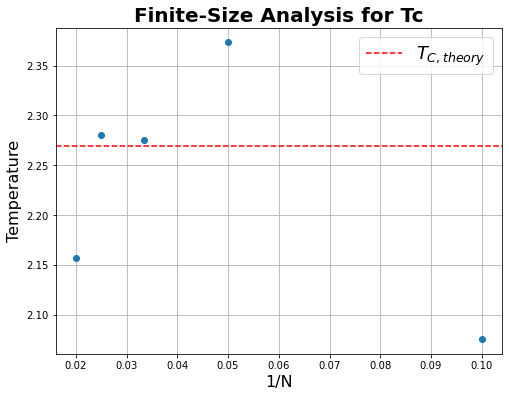

In [77]:
def powerlaw(x, A=1, v=1., b=2.2):
    return A * np.power(x, v) + b

#fit
n=[1/n for n in N]
sol, cov = curve_fit(powerlaw, n, TCs, maxfev=int(1e6) )

#plot
plt.figure(figsize=(8,6))
plt.plot(n, TCs, 'o')
plt.xlabel('1/N',fontsize=16)
plt.ylabel('Temperature',fontsize=16)
plt.title('Finite-Size Analysis for Tc', fontsize = 20, fontweight = "bold")
plt.axhline(y=2/np.log(1+np.sqrt(2)), linestyle='--', color=('red'), label='$T_{C,theory}$')
plt.grid()
plt.legend(fontsize=18)
plt.show()

Again, the lack of data dosen't allow to perform an appropriate finite size analysis; anyway we can observe how our points are distributed in a reasonable way around the true value.

## Ergodicity Breaking

In addition to the $2^{nd}$ order phase transition, the Ising Model is a good system to understand also the *ergodicity breaking transition*. <br>
As a matter of fact, with our simulation it is possible to observe how the systems, over the critical point, is ergodic and can explore all the configurations $\{\vec{\sigma}\}$. While, cooling under the critical, is clear that model lose the ergodicity property and remains confined in a restricted portion of the phase space. <br>
To investigate this behaviour we propose three different situation.

1) For $T>T_c$ the free energy $f$ presents a single minimum in correspondence of $m=0$

---------- ISING MODEL ----------
N: 10 , beta: 0.35 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


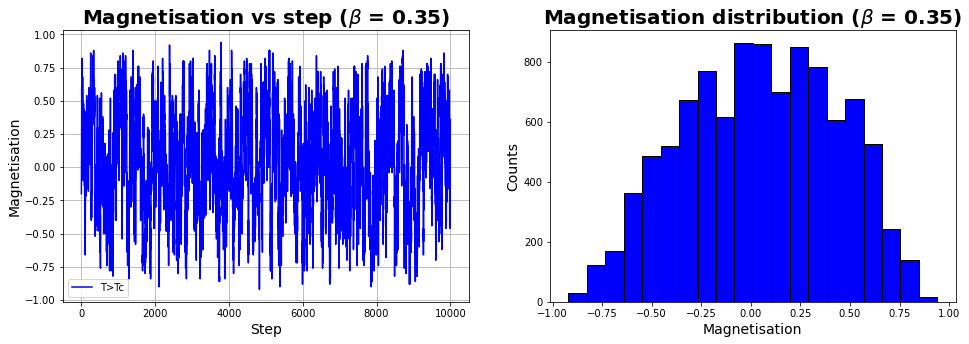

In [78]:
N = 10
beta = 0.35
T = 1/beta

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_T  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e4))

#plot
plt.figure(figsize=(16,5))
ax=plt.subplot(1,2,1)
ax.plot(M_T / N**2, 'blue', label='T>Tc')
ax.set_title(r'Magnetisation vs step ($\beta$ = {})'.format(beta), fontsize = 20, fontweight = "bold" )
ax.set_ylabel('Magnetisation', fontsize=14)
ax.set_xlabel('Step', fontsize=14)
ax.grid()
ax.legend()

#hist
ax0=plt.subplot(1,2,2)
ax0.hist(M_T / N**2, align='mid', ec='black', bins=20, color='blue')
ax0.set_title(r'Magnetisation distribution ($\beta$ = {})'.format(beta), fontsize = 20, fontweight = "bold" )
ax0.set_xlabel('Magnetisation', fontsize=14)
ax0.set_ylabel('Counts', fontsize=14)

plt.show()

2) For $T=T_c$ the free energy $f$ presents two coincident mimima in $m=0$

---------- ISING MODEL ----------
N: 10 , beta: 0.44068679350977147 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


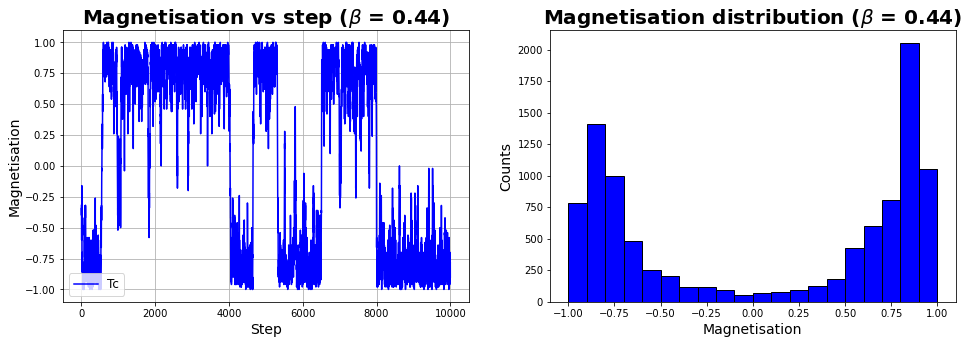

In [79]:
N = 10
Tc= 2 / np.log(1 + np.sqrt(2))
beta = 1/Tc

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_Tc  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e4))

#plot
plt.figure(figsize=(16,5))
ax=plt.subplot(1,2,1)
ax.plot(M_Tc / N**2, 'blue', label='Tc')
ax.set_title(r'Magnetisation vs step ($\beta$ = 0.44)', fontsize = 20, fontweight = "bold" )
ax.set_ylabel('Magnetisation', fontsize=14)
ax.set_xlabel('Step', fontsize=14)
ax.grid()
ax.legend(loc='lower left', fontsize=12, )

#hist
ax0=plt.subplot(1,2,2)
ax0.hist(M_Tc / N**2, color='blue', align='mid', ec='black', bins=20)
ax0.set_title(r'Magnetisation distribution ($\beta$ = 0.44)', fontsize = 20, fontweight = "bold" )
ax0.set_xlabel('Magnetisation', fontsize=14)
ax0.set_ylabel('Counts', fontsize=14)

plt.show()

3) For $T<T_c$ the free energy $f$ has two diffrent minima in $\pm m^*$

---------- ISING MODEL ----------
N: 10 , beta: 4.0 , cluster: False , annealing: True 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 10 , beta: 4.0 , cluster: False , annealing: True 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


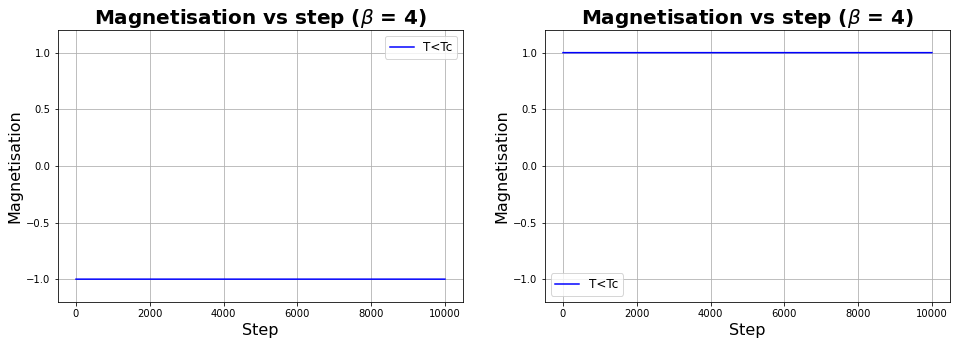

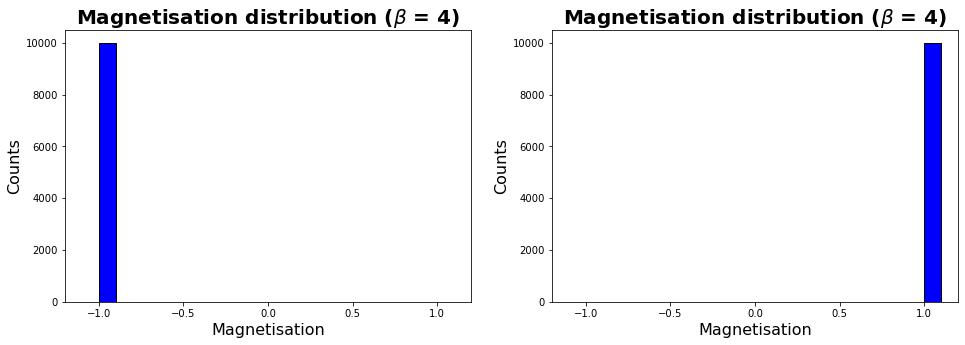

In [82]:
N = 10
T=0.25
beta = 1/T

n_simulation=2
M_Ts=[]

#simultaion
for i in range(n_simulation):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_t  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e4), annealing=True)
    M_Ts.append(M_t)
    
#plot
plt.figure(figsize=(16,5))
for i in range(n_simulation):    
    ax0=plt.subplot(1,n_simulation,i+1)
    ax0.set_ylim([-1.2, 1.2])
    ax0.plot(M_Ts[i] / N**2, color='blue', label='T<Tc')
    ax0.set_title(r'Magnetisation vs step ($\beta$ = 4)', fontsize = 20, fontweight = "bold" )
    ax0.set_ylabel('Magnetisation', fontsize=16)
    ax0.set_xlabel('Step', fontsize=16)
    ax0.grid()
    ax0.legend(fontsize=12)
plt.show()

#hist
plt.figure(figsize=(16,5))
for i in range(n_simulation):
    ax=plt.subplot(1,n_simulation,i+1)
    ax.set_xlim([-1.2, 1.2])
    ax.hist(M_Ts[i] / N**2, align='mid', ec='black', bins=10, color='blue')
    ax.set_title(r'Magnetisation distribution ($\beta$ = 4)', fontsize = 20, fontweight = "bold" )
    ax.set_ylabel('Counts', fontsize=16)
    ax.set_xlabel('Magnetisation', fontsize=16)
plt.show()

# **Critical slowing down**

The main challenging problem that we encounter when simulating the Ising model is the so-called *critical slowing down*. We observe, indeed, how the Monte Carlo methods struggle and lead to poor performances approaching the critical point. <br>
To quantify this effect we start to study how the data are correlated.

## Correlated Data

We know that Monte Carlo algorithms can be seen as Markov chains, in the sense that the updated state depends from the previous one. For this reason it is necessary to study how the states are correlated with each other.
In a more quantitative way we take in cosideration the autocorrelation function for different values of temperature.
$$ ACF(\tau) = \dfrac{\langle (x_t - \overline{x} )(x_{t+\tau} - \overline{x})\rangle}{\langle (x_t - \overline{x} )^2\rangle} $$

In [84]:
#--- Computing τ for different TEMPERATURES -----------
N = 40
eq_steps = int(1e4)
steps = int(1e3)


Tc= 2 / np.log(1 + np.sqrt(2))
Ts = np.array([Tc-1, Tc, Tc+1])
N_T = len(Ts)
betas = 1 / Ts

Eeq_s_t = np.zeros((N_T,eq_steps))
Meq_s_t = np.zeros((N_T,eq_steps))
Es_t = np.zeros((N_T, steps))
Ms_t = np.zeros((N_T, steps))

#--- Simulation
for i, beta in enumerate(betas):
    E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq_t, M_eq_t, E_t, M_t,  = Ising(N, beta, eq_steps=eq_steps, steps=steps)

    Eeq_s_t[i] = E_eq_t
    Meq_s_t[i] = M_eq_t
    Es_t[i] = E_t
    Ms_t[i] = M_t

#--- Compute ACF
corr_varT = []
num_lag=200

for i, T in enumerate(Ts):
    tmp = acf(Ms_t[i], nlags=num_lag)
    corr_varT.append(tmp)


---------- ISING MODEL ----------
N: 40 , beta: 0.7879070052272591 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 40 , beta: 0.44068679350977147 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 40 , beta: 0.3058866059542195 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


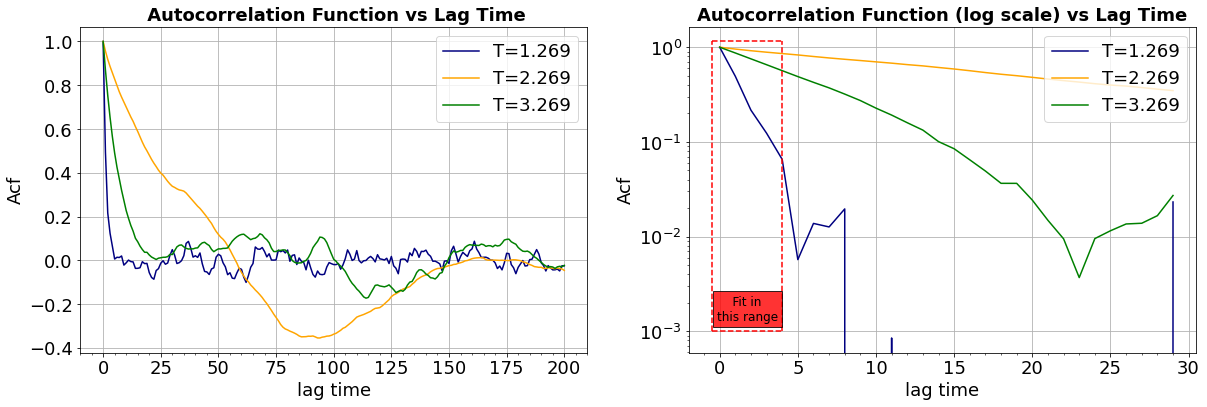

In [92]:
#--- Plot-
colors = ["navy", "orange", "green"]

plt.figure(figsize=(20,6))
ax0 = plt.subplot(1,2,1)

for i,x in enumerate(corr_varT):
    ax0.plot(x, label='T='+str('%.3f'%Ts[i]), c = colors[i])

ext=30
ax0.set_xlabel('lag time', fontsize = 18)
ax0.set_ylabel('Acf', fontsize = 18)
ax0.set_title(' Autocorrelation Function vs Lag Time', fontsize = 18, fontweight = "bold" )
ax0.tick_params(axis="x",labelsize=18)
ax0.tick_params(axis="y",labelsize=18)

ax0.xaxis.set_minor_locator(MultipleLocator(5))
ax0.grid()
ax0.legend(fontsize = 18)

ax1=plt.subplot(1,2,2)
for i,x in enumerate(corr_varT):
    ax1.plot(x[:ext], label='T='+str('%.3f'%Ts[i]),c = colors[i] )

ax1.set_yscale('log')
ax1.set_xlabel('lag time', fontsize = 18)
ax1.set_ylabel('Acf', fontsize = 18)
ax1.set_title('Autocorrelation Function (log scale) vs Lag Time', fontsize = 18, fontweight = "bold" )
ax1.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)

ax1.plot([4,4],[0.001,1.15],'r--') # start plot the red box
ax1.plot([-0.5,-0.5],[0.001,1.15],'r--')
ax1.plot([-0.5,4],[1.15,1.15],'r--')
ax1.plot([-0.5,4],[0.001,0.001],'r--') # end plot the red box
ax1.text(0.055,0.1,'    Fit in \nthis range',
         transform=ax1.transAxes,bbox=dict(facecolor='red', alpha=0.8), fontsize=12)
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax1.grid()
ax1.legend(loc='upper right', fontsize = 18)
plt.show()

From this plot we can observe, in particular, how the autocorrelation approaches to zero very slowing nearby the critical temperature. This is precisely the phenomenon of the critical slowing down.
<br>
For every value of the temperature we can fit this curves with an exponential and find the charatterstic time $\tau$, in this way:

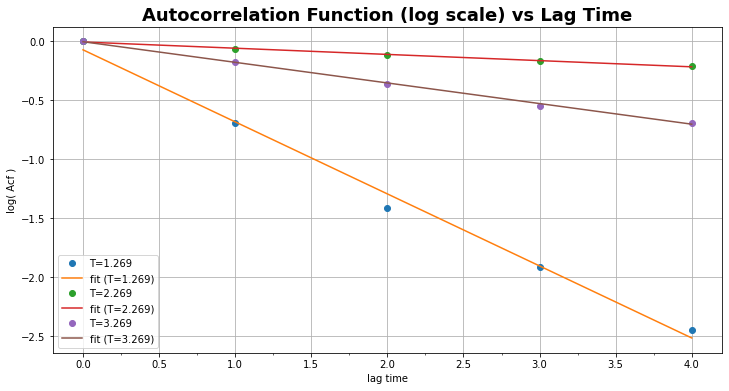


The values of τ for each temperature is: 

	T=1.269 ---> τ=1.638

	T=2.269 ---> τ=19.017

	T=3.269 ---> τ=5.725


In [ ]:
def func(x, m, q):
    return m*x + q

end_step=4
lag = np.arange(len(corr_varT[0][:end_step+1]))
tau_list=[]
parameters=[]

#git
for i,temp in enumerate(corr_varT):
    t=np.arange(0,end_step+1)
    sol = curve_fit(func, lag, np.log(corr_varT[i][:end_step+1]) )
    tau_list.append(-1/sol[0][0])
    parameters.append(sol[0])

#plot
plt.figure(figsize=(12,6))
ax2=plt.subplot(1,1,1)
for i,x in enumerate(corr_varT):
    ax2.plot(np.log(x[:end_step+1]),'o', label='T='+str('%.3f'%Ts[i]))
    ax2.plot( (parameters[i][0])*(np.arange(end_step+1)) + parameters[i][1] , '-', label='fit (T={})'.format('%.3f'%Ts[i]))
ax2.set_xlabel('lag time')
ax2.set_ylabel('log( Acf )')
ax2.set_title('Autocorrelation Function (log scale) vs Lag Time', fontsize = 18, fontweight = "bold" )
ax2.xaxis.set_minor_locator(MultipleLocator(0.25))
ax2.grid()
ax2.legend()
plt.show()

#print
print('\nThe values of τ for each temperature is: ')
for i,temp in enumerate(Ts):
  print('\n\tT={} ---> τ={}'.format('%.3f'%temp, '%.3f'%tau_list[i]))

It is therefore clear that, in proximty of the critical temperature, the characteristic time of the correlation function grows abruptly. This behaviour dramatically affect the performances of the algorithm and get worse enlarging the size of the systems, how we see next. 

---------- ISING MODEL ----------
N: 50 , beta: 0.44068679350977147 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 100 , beta: 0.44068679350977147 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 150 , beta: 0.44068679350977147 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


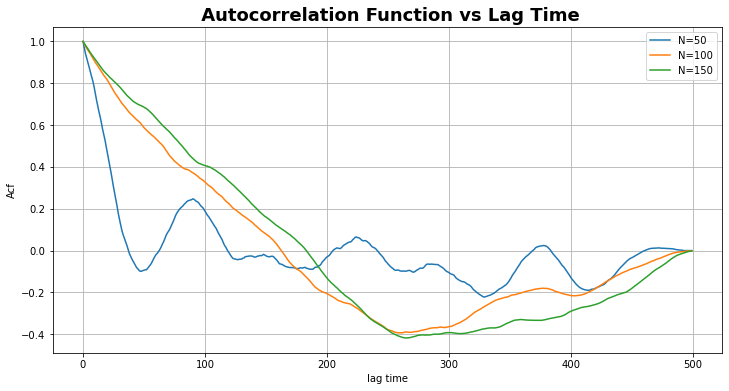


The values of τ for each lattice size is: 

	T=50.000 ---> τ=27.009

	T=100.000 ---> τ=97.793

	T=150.000 ---> τ=113.375


In [93]:
#--- Computing τ for different LATTICE SIZE N at T=Tc -----------

N_n = np.arange(50,151,50)
N_N=len(N_n)

eq_steps = int(5e2)
steps = int(5e2)

Tc= 2 / np.log(1 + np.sqrt(2))
beta = 1 / Tc

Eeq_s_n = np.zeros((N_N,eq_steps))
Meq_s_n = np.zeros((N_N,eq_steps))
Es_n = np.zeros((N_N, steps))
Ms_n = np.zeros((N_N, steps))

#--- Simulation
for i, n in enumerate(N_n):
  E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq_n, M_eq_n, E_n, M_n,  = Ising(n, beta, eq_steps=eq_steps, steps=steps)

  Eeq_s_n[i] = E_eq_n
  Meq_s_n[i] = M_eq_n
  Es_n[i] = E_n
  Ms_n[i] = M_n

#--- Compute ACF
corr_varN2 = []
num_lag=600
for i, n in enumerate(N_n):
  
    tmp = acf(Ms_n[i], nlags=num_lag)
    corr_varN2.append(tmp)

#--- Plot
plt.figure(figsize=(12,6))
ax3=plt.subplot(1,1,1)
for i,x in enumerate(corr_varN2):
    ax3.plot(x, label='N='+str(N_n[i]))

ax3.set_xlabel('lag time')
ax3.set_ylabel('Acf')
ax3.set_title(' Autocorrelation Function vs Lag Time', fontsize = 18, fontweight = "bold" )
ax3.grid()
ax3.legend()
plt.show()

#--- Fit
def func(x, m, q):
    return m*x + q

print('\nThe values of τ for each lattice size is: ')
end_step=20
lag2 = np.arange(len(corr_varT[0][:end_step+1]))
tau_list_2=[]
parameters_2=[]
for i,temp in enumerate(N_n):
    t=np.arange(0,end_step+1)
    sol2 = curve_fit(func, lag2, np.log(corr_varN2[i][:end_step+1]) )
    tau_list_2.append(-1/sol2[0][0])
    parameters_2.append(sol2[0])
    print('\n\tT={} ---> τ={}'.format('%.3f'%temp, '%.3f'%tau_list_2[i]))

## Cluster-Flip Dynamics

We have seen how, increasing of the size of the system and in the proximity of the critical temperature, the performances of the algorithm based on the Single-Flip dynamic drops dramatically.

To solve this problem we implement a Cluster-Flip dynamics following the Wolff algorithm.

In this case:

- the selection probability is again uniform
<br>
$$g(\sigma \rightarrow \sigma') = \dfrac{\sum_{i \in cluster} i}{N^2} $$
- while the acceptance probabilities follow this proportionality:

$$A(\sigma \rightarrow \sigma') \propto (1-p)^n \qquad A(\sigma' \rightarrow \sigma) \propto (1-p)^m $$
<br>
where $p$ is a fixed probability of accepting aligned neighboring spins in the cluster, $n$ is the number of the alligned spins that aren't accepted with probability $p$ before spin-flip process and $m$ is the number of the aligned neighboring spins of the cluster after the spins-flip process.

Now, imposing the detailed balanced condition to the transition probabilities, we obtain:
$$ \dfrac{P(\sigma')}{P(\sigma)} = e^{ - \beta ( E_{\sigma'} - E_{\sigma} ) }$$
The equation to satisfy becomes
<br>
$$e^{ - \beta (m-n) } (1-p)^n W(\sigma \rightarrow \sigma') = e^{ - \beta(n-m) } (1-p)^m W(\sigma' \rightarrow \sigma)$$ 
And we end up to 
$$ W(\sigma \rightarrow \sigma') = \min( 1 , \dfrac{e^{-\beta(n-m)} }{ (1-p)^n} \dfrac{(1-p)^m}{ e^{- \beta (m-n)} }) $$

Finally, using the probability $p=1-e^{-2J \beta }$ (with $J=1$) we obtain that the cluster spins will be always flipped after each iteration.

In [95]:
#@jit(nopython = True)
def add(state, beta, starting, cluster):
    '''
    Add a spin to the cluster
    '''
    
    #get lattice size
    L = state.shape[0] 
    N = L**2
    
    #prob to add a spin to the cluster
    p_add = 1. - np.exp(-2*beta) 
    
    #get indexes of starting spin
    i, j = starting[0], starting[1] 
    
    #get neighbors
    nbr = np.array([ [(i - 1)%L, j], [(i + 1)%L, j], [i, (j - 1)%L], [i, (j + 1)%L] ])
    
    starting_spin = state[i, j]
    
    #list to store accepted spins
    new_elements = []
    
    for n in nbr:
       #add spin
        if state[n[0], n[1]] == starting_spin and [n[0], n[1]] not in cluster \
        and np.random.uniform(0., 1.) < p_add:
        
            new_elements.append([n[0], n[1]])
            
    #add elements to the cluster       
    cluster += new_elements
    
    return cluster

#@jit(nopython = True)
def wolff(state, beta):
    '''
    Flip the cluster
    '''
    
    #get lattice size
    L = state.shape[0] 
    N = L**2
        
    #get random spin    
    i, j = np.random.randint(L), np.random.randint(L)
    
    #the random spin is the first element of the cluster
    cluster = [[i,j]] 
        
    #build the cluster
    for elem in cluster:
        cluster = add(state, beta, elem, cluster)
        
    #flip the cluster       
    for elem in cluster:
        state[elem[0], elem[1]] *= -1
        
    return state

### Example of Cluster-Flip

Example of cluster flip:


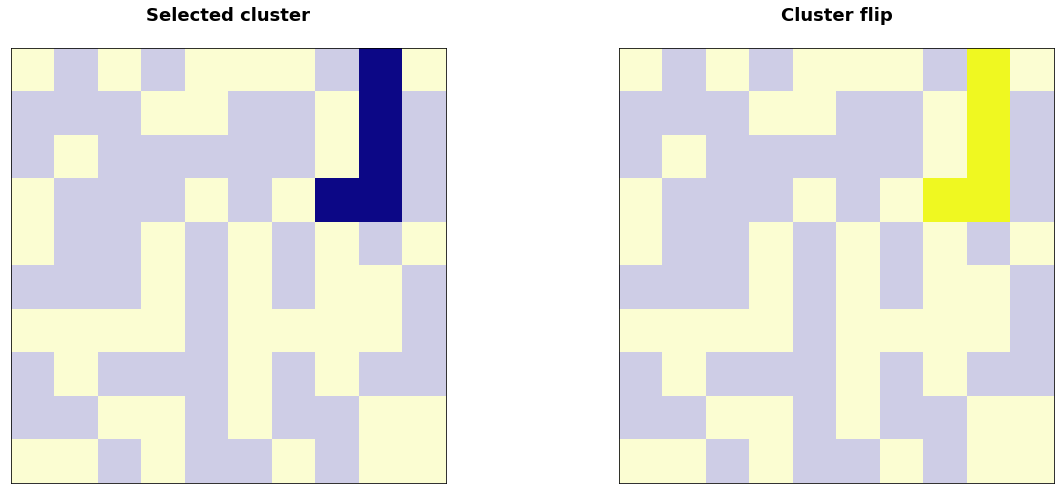

In [97]:
#example of Cluster-Flip
N = 10
beta = 0.5
state = init_state(N)
state1 = state.copy()

alpha = np.full((N,N), 0.2)
new_state = wolff(state1, beta)

cluster = []
for i in range(N):
    for j in range(N):
        if state[i,j] != new_state[i, j]:
            cluster.append([i,j])

for s in cluster:
    alpha[s[0], s[1]] = 1
print("Example of cluster flip:")

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,8))
ax1.matshow(state, cmap = plt.cm.plasma, alpha = alpha)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Selected cluster", fontsize = 18, fontweight = "bold")
ax2.matshow(new_state, cmap = plt.cm.plasma, alpha = alpha)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Cluster flip", fontsize = 18, fontweight = "bold")
plt.show()

### Autocorrelation with Wolff

Next we show exactly what happens near the critical temperature ($\beta = 0.44$). We compare the two dynamics (single-flip in blue and cluster-flip in orange), for the same size, to highlight how the Wolff algorithm "breaks" the characteristic time $\tau$ of the correlation function.

---------- ISING MODEL ----------
N: 20 , beta: 0.44 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...
---------- ISING MODEL ----------
N: 20 , beta: 0.44 , cluster: True , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


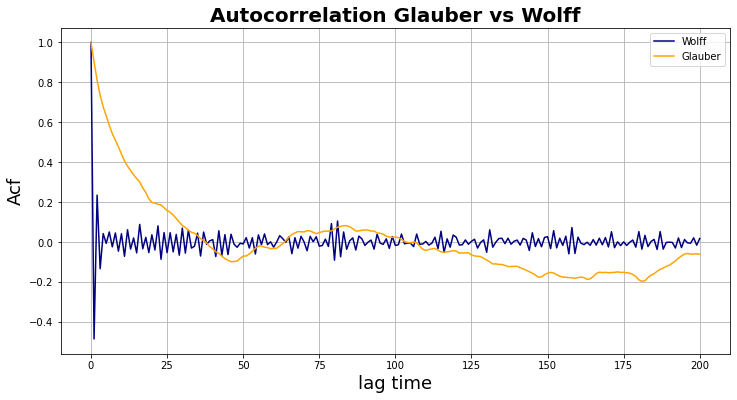

In [101]:
N = 20
beta = 0.44

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_G,  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e3))
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_W,  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e3), cluster=True)

#compute Acf
tmpG = acf(M_G, nlags=200) 
tmpW = acf(M_W, nlags=200)

#plot
plt.figure(figsize=(12,6))
plt.plot(tmpW, label='Wolff', color='navy')
plt.plot(tmpG, label='Glauber', color='orange')
plt.title('Autocorrelation Glauber vs Wolff', fontsize=20, fontweight = "bold")
plt.xlabel('lag time', fontsize=18)
plt.ylabel('Acf', fontsize=18)
plt.grid()
plt.legend()
plt.show()

## Verification of the correct working of Glauber and Wolff algorithms using $m$ as order parameter

It is possible to use the magnetisation $m$ as order parameter to verify the proper operation of the two algorthms. We know that when $T\rightarrow T_c$, the magnetisation is zero $m=0$.

#### Glauber algorithm

---------- ISING MODEL ----------
N: 10 , beta: 0.44 , cluster: False , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


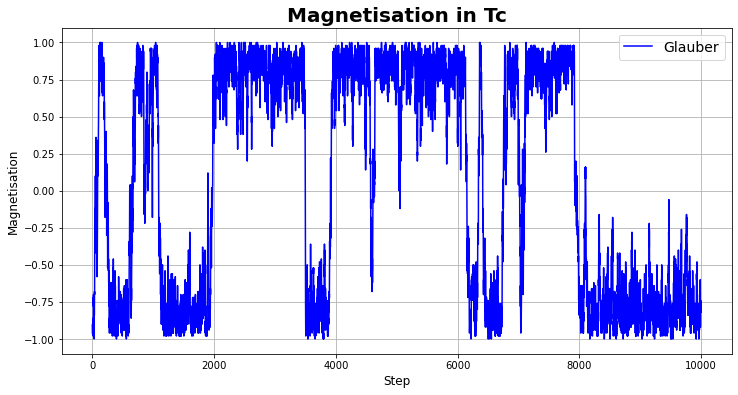

The Glauber magnetisation is: 0.085536


In [106]:
N = 10
beta = 0.44

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_G  = Ising(N, beta, eq_steps=int(1e4), steps=int(1e4))

#plot
plt.figure(figsize=(12,6))
plt.plot(M_G / N**2, 'blue', label='Glauber')
plt.title('Magnetisation in Tc', fontsize = 20, fontweight = "bold")
plt.xlabel('Step', fontsize=14)
plt.ylabel('Magnetisation', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid()
plt.show()

#compute m mean
MG = np.mean(M_G) /N**2
print('The Glauber magnetisation is:', MG)

#### Wolff algorithm

---------- ISING MODEL ----------
N: 10 , beta: 0.44 , cluster: True , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


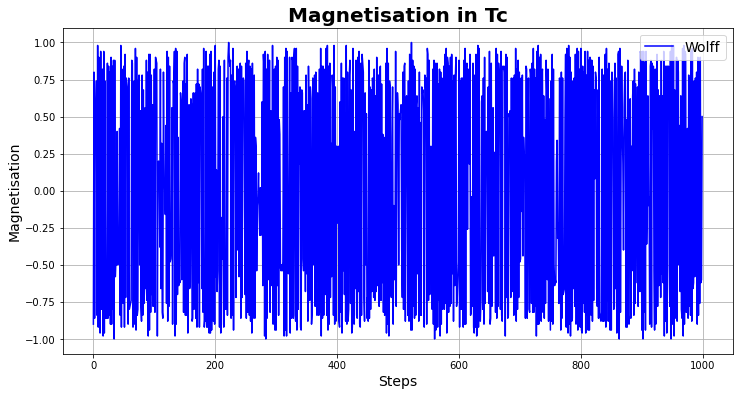

The Wolff magnetisation is: 0.0025


In [113]:
N = 10
beta = 0.44

#simulation
E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M_W  = Ising(N, beta, eq_steps=int(1e2), steps=int(1e3), cluster=True)

#plot
plt.figure(figsize=(12,6))
plt.plot(M_W / N**2, 'blue', label='Wolff')
plt.title('Magnetisation in Tc', fontsize = 20, fontweight = "bold")
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Magnetisation', fontsize=14)
plt.grid()
plt.legend(loc='upper right', fontsize=14)
plt.show()

#compute m mean
MW = np.mean(M_W) /N**2
print('The Wolff magnetisation is:', '%.4f'%MW)

In this way we see that both the dynamics correctly simulate the model, but the Wolff algortihm is more precise of an order of magnitude.

## Visualization of the different dynamics between Glauber and Wolff

As can be seen, the Single Spin Flip update seems to thermalize quicker than the Wolff algorithm, however the latter has the advantage of smaller autocorrelation times, i.e. the state of the system changes quicker. This reduces the correlation of consecutive measurements, thereby facilitating data analysis of deduced quantities and improving accuracy.

In [130]:
def plot_states(states, Ts, index=0, save=False):
  '''
  Handler for plotting and saving frames.
  '''
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

  for i, ax in enumerate(axes.flat):
    ax.imshow(states[i], animated=True)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title('T='+str(Ts[i]))

  plt.tight_layout()
  fig.savefig('images/Wolff/'+str(index)+'.png', dpi=fig.dpi)
  plt.close()
  
  return axes

In [131]:
N = 100
Ts = np.arange(0.5, 3.5, 0.5)
#print(Ts)

# Init states
states = np.zeros((len(Ts), N, N))

for i in range(len(Ts)):
    states[i] = init_state(N)

# Evolve
steps = int(1e2)

for i in tqdm(range(steps)):
    for t in range(len(Ts)):
        states[t] = wolff(states[t], 1/Ts[t])
    #if i%1e2==0 and (not i==0):
    plot_states(states, Ts, index=i, save=True)

In [133]:
import os

png_dir = 'images/Wolff/'
images = []

names = []

# Get names
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        names.append(file_name)
        
# Sort names
names = sorted(names, key=lambda x: int(x.split('.')[0]))

# Create gif
for name in names:
    file_path = os.path.join(png_dir, name)
    images.append(imageio.imread(file_path))
imageio.mimsave('movieW.gif', images)

####                       Glauber Dynamic

![SegmentLocal](movieG.gif "segment")

####                      Wolff Dynamic

![SegmentLocal](movieW.gif "segment")

## Some analysis with the Wolff algortihm

As last thing we try to simulate the system with the Wolff algortihm and we check how it reaches the equilibrium near the critical temperature


beta: 0.44
---------- ISING MODEL ----------
N: 40 , beta: 0.44 , cluster: True , annealing: False 

Start equilibration...



End equilibration...

Start simulation...



End simulation...


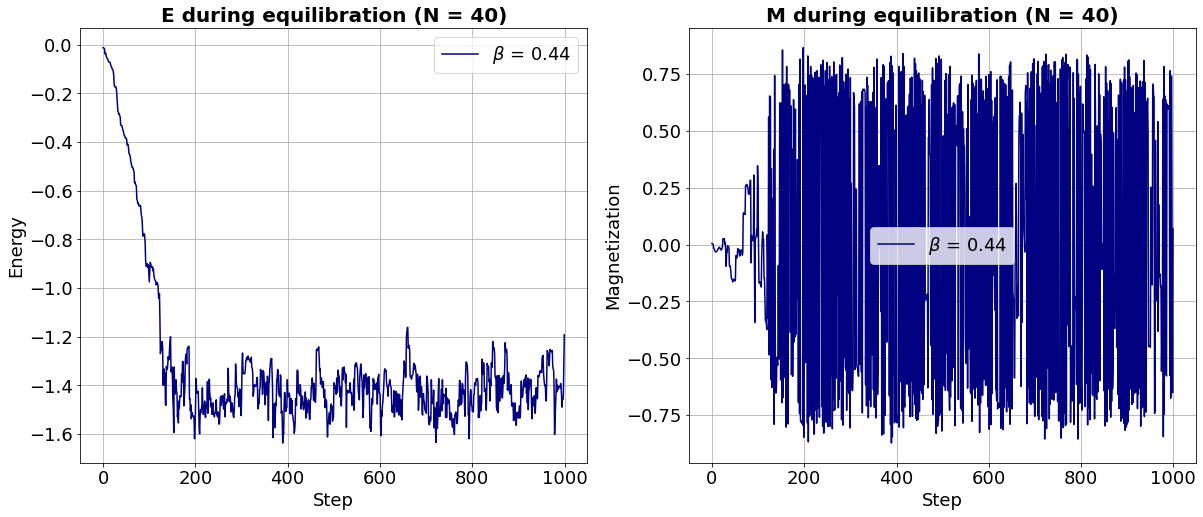

In [132]:
N = 40 #size of lattice
eq_steps = 1000 #define number of equilibration steps
steps = 100
betas = np.array([0.44]) #values of beta to be used
col_map = np.array(["navy", "red", "green", "orange"])

#create plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
ax1.set_title(r"E during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {})".format(N), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)
ax1.grid()
ax2.grid()

#loop over betas and compute values
for i in range(len(betas)):
    print("\nbeta:", betas[i])
    
    E_mean, M_mean, C, Chi, E_var, M_var, E_eq, M_eq, E, M = Ising(N, betas[i], eq_steps, steps, cluster=True)
    
    ax1.plot(E_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    ax2.plot(M_eq/N**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    
ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()

# **Conclusion**

In this project we managed to:
- simulate the Ising Model,
- observe the phenomena of phase transition and ergodicity breaking,
- infere a value for the critical exponent $\gamma$ and for the critical temperature $T_c$,
- deal with the critical slowing down and implement the cluster dynamics to overcome this effect.

To deepen the application of Monte Carlo algorthm to this type of systems, the next step will be a study on how to collect uncorrelated data using the characteristic time of the correlation function.
<br>
A further improvement will be to collect more data near the critical temperature (maybe with the help of the Wolff algorithm) to perform a better finite-size analysis.